In [7]:
import pandas as pd
import numpy as np

import os
import pickle

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model  import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

In [8]:
tweets = pd.read_csv('trainDatasets/features_generadas.csv') #carga de modelo generado con tweets de usuarios
users = pd.read_pickle('trainDatasets/users_dataset.pkl')

In [9]:
tweetsDf = tweets.copy()
tweetsDf.index = tweetsDf.user_id.apply(lambda x: int(x)).values
tweetsDf.loc[:,'user_id'] = tweetsDf.user_id.apply(lambda x: int(x))
usersDf = users.copy()
usersDf.rename(columns={'id':'user_id'}, inplace=True)
usersDf.index = users.index.map(lambda x: int(x))

In [10]:
display(usersDf.sort_index().head(2))
display(tweetsDf.sort_index().head(2))

,user_id,screen_name,complete_name,description,verified,crawled_at,location,url,created_at,tweet_count,listed_count,favs_count,followers_count,following_count,bot,user_type
678033,678033,heathr,Heather Gold,Comic. Writer. Speaker. My heart is hardwired ...,NaN,2015-05-01 12:57:24,OAK,http://t.co/98fWa0t873,Mon Jan 22 01:57:38 +0000 2007,45825,596,3804,7065,1822,False,Human
722623,722623,BuzzJackson,Buzz Jackson,Blah Blah Blah every afternoon on @KIIM995 in ...,NaN,2015-05-01 12:57:52,"Tucson, Arizona",http://t.co/lQpx4IMpV1,Mon Jan 29 00:54:34 +0000 2007,11770,47,634,1577,678,False,Human


,user_id,user_id.1,bot,Cat,tweetsCount,semanas,lun,mar,mie,jue,...,num_mentions_mean,num_mentions_median,num_mentions_std,num_mentions_fq,num_mentions_tq,reply_count_mean,reply_count_median,reply_count_std,reply_count_fq,reply_count_tq
678033,678033,678033.0,False,Humans,300,4,12.666667,17.666667,8.333333,19.333333,...,9313.304721,10000.0,8781.379387,0.0,10000.0,0.0,0.0,0.0,0.0,0.0
722623,722623,722623.0,False,Humans,300,10,4.444444,4.000000,3.888889,4.600000,...,5591.836735,0.0,6086.528956,0.0,10000.0,0.0,0.0,0.0,0.0,0.0


In [11]:
completeDf = usersDf.join(tweetsDf.drop(['bot'], axis=1), how='inner', lsuffix='__l')

In [12]:
class twDataTransform(TransformerMixin):
    def fit(self, X, Y):
        return self
    def transform(self, X, Y=None):
        df = X
        try:
            df.loc[:, 'crawled_at'] = pd.DatetimeIndex(pd.to_datetime(df.crawled_at, utc=None)).tz_convert(tz='UTC')
            df.loc[:, 'created_at'] = pd.DatetimeIndex(pd.to_datetime(df.created_at, utc=None)).tz_convert(tz='UTC')
        except:
            try:
                df.loc[:, 'crawled_at'] = pd.DatetimeIndex(pd.to_datetime(df.crawled_at, utc=None)).tz_localize(tz='UTC')
                df.loc[:, 'created_at'] = pd.DatetimeIndex(pd.to_datetime(df.created_at, utc=None)).tz_localize(tz='UTC')
            except:
                df.loc[:, 'crawled_at'] = pd.DatetimeIndex(pd.to_datetime(df.crawled_at, utc=None)).tz_convert(tz='UTC')
                df.loc[:, 'created_at'] = pd.DatetimeIndex(pd.to_datetime(df.created_at, utc=None)).tz_convert(tz='UTC')
        account_life = df.crawled_at - df.created_at
        account_life_meses = np.round(account_life.dt.days / 30)
        account_life_meses = account_life_meses.replace(0, 1)
        account_life_semanas = np.round(account_life.dt.days / 7)
        account_life_semanas = account_life_semanas.replace(0, 1)
        numValues = ['tweet_count', 'listed_count', 'followers_count', 'following_count']
        for i in numValues:
            colName_mes = i+'_mes'
            df.loc[:,colName_mes] = df[i] / account_life_meses

            colName_semana = i+'_semana'
            df.loc[:,colName_semana] = df[i] / account_life_semanas

#         df.loc[:,'verified'] = ~df.verified.isna()
#         df.loc[:,'description'] = ~df.description.isna()
#         df.loc[:,'location'] = ~df.location.isna()
#         df.loc[:,'url'] = ~df.url.isna()

        columnas = np.concatenate(
            [[x+'_mes'] for x in numValues]
        )
#         columnas = np.concatenate([
#             [
#                 'verified',
#                 'description',
#                 'location',
#                 'url',
#             ],
#             columnas
#         ])
        columnasTweets = np.concatenate(
            [
                [x+'_mean',x+'_median', x+'_std', x+'_fq', x+'_tq'] for x in
                ['times','timesRT','timesUser','favorite_count','retweet_count','num_mentions','reply_count']
            ]
        )
        columnas = np.concatenate([
            ['semanas', 'lun', 'mar', 'mie', 'jue', 'vie', 'sab', 'dom'],columnas,columnasTweets
        ])
        df = df[columnas]
        df = df.fillna(0)
        return df
#     def fit_transform(self, X, Y=None):
#         self.fit(X, Y)
#         return self.transform(X, Y)

pipeline = Pipeline([
    ('sel', twDataTransform()),
    ('scaler', StandardScaler()),
    ('cat', CatBoostClassifier())
])

le = preprocessing.LabelEncoder()
# x = transform_x(users)
x = completeDf
y =  le.fit_transform(completeDf['bot'])

X_train, X_test, y_train, y_test = train_test_split(x, y)

pipeline.fit(X_train, y_train)

C:\Users\matias\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\matias\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


Learning rate set to 0.025637
0:	learn: 0.6339392	total: 124ms	remaining: 2m 4s
1:	learn: 0.5774600	total: 169ms	remaining: 1m 24s
2:	learn: 0.5292386	total: 216ms	remaining: 1m 11s
3:	learn: 0.4797107	total: 262ms	remaining: 1m 5s
4:	learn: 0.4294448	total: 306ms	remaining: 1m
5:	learn: 0.3949108	total: 347ms	remaining: 57.5s
6:	learn: 0.3648783	total: 395ms	remaining: 56s
7:	learn: 0.3346081	total: 439ms	remaining: 54.4s
8:	learn: 0.3089128	total: 481ms	remaining: 53s
9:	learn: 0.2886815	total: 522ms	remaining: 51.7s
10:	learn: 0.2673837	total: 567ms	remaining: 51s
11:	learn: 0.2488848	total: 613ms	remaining: 50.5s
12:	learn: 0.2311253	total: 655ms	remaining: 49.8s
13:	learn: 0.2161302	total: 699ms	remaining: 49.2s
14:	learn: 0.2015200	total: 740ms	remaining: 48.6s
15:	learn: 0.1894419	total: 785ms	remaining: 48.3s
16:	learn: 0.1774571	total: 830ms	remaining: 48s
17:	learn: 0.1673297	total: 872ms	remaining: 47.6s
18:	learn: 0.1551543	total: 922ms	remaining: 47.6s
19:	learn: 0.1446407

160:	learn: 0.0276402	total: 6.98s	remaining: 36.4s
161:	learn: 0.0275870	total: 7.02s	remaining: 36.3s
162:	learn: 0.0275391	total: 7.06s	remaining: 36.3s
163:	learn: 0.0274715	total: 7.1s	remaining: 36.2s
164:	learn: 0.0273677	total: 7.15s	remaining: 36.2s
165:	learn: 0.0273236	total: 7.19s	remaining: 36.1s
166:	learn: 0.0272362	total: 7.23s	remaining: 36.1s
167:	learn: 0.0271234	total: 7.27s	remaining: 36s
168:	learn: 0.0270721	total: 7.31s	remaining: 35.9s
169:	learn: 0.0270626	total: 7.35s	remaining: 35.9s
170:	learn: 0.0269103	total: 7.4s	remaining: 35.9s
171:	learn: 0.0267843	total: 7.44s	remaining: 35.8s
172:	learn: 0.0266525	total: 7.48s	remaining: 35.8s
173:	learn: 0.0266380	total: 7.52s	remaining: 35.7s
174:	learn: 0.0266028	total: 7.56s	remaining: 35.7s
175:	learn: 0.0265996	total: 7.59s	remaining: 35.5s
176:	learn: 0.0265251	total: 7.63s	remaining: 35.5s
177:	learn: 0.0265162	total: 7.67s	remaining: 35.4s
178:	learn: 0.0264149	total: 7.71s	remaining: 35.4s
179:	learn: 0.02

319:	learn: 0.0196864	total: 13.4s	remaining: 28.6s
320:	learn: 0.0196837	total: 13.5s	remaining: 28.5s
321:	learn: 0.0196821	total: 13.5s	remaining: 28.4s
322:	learn: 0.0196489	total: 13.5s	remaining: 28.4s
323:	learn: 0.0196324	total: 13.6s	remaining: 28.4s
324:	learn: 0.0195664	total: 13.6s	remaining: 28.3s
325:	learn: 0.0195499	total: 13.7s	remaining: 28.3s
326:	learn: 0.0195273	total: 13.7s	remaining: 28.2s
327:	learn: 0.0195256	total: 13.8s	remaining: 28.2s
328:	learn: 0.0195001	total: 13.8s	remaining: 28.1s
329:	learn: 0.0194624	total: 13.8s	remaining: 28.1s
330:	learn: 0.0194599	total: 13.9s	remaining: 28.1s
331:	learn: 0.0194530	total: 13.9s	remaining: 28s
332:	learn: 0.0194411	total: 14s	remaining: 28s
333:	learn: 0.0192877	total: 14s	remaining: 27.9s
334:	learn: 0.0192669	total: 14s	remaining: 27.9s
335:	learn: 0.0192492	total: 14.1s	remaining: 27.8s
336:	learn: 0.0192112	total: 14.1s	remaining: 27.8s
337:	learn: 0.0191756	total: 14.2s	remaining: 27.8s
338:	learn: 0.0191253	

479:	learn: 0.0156470	total: 20s	remaining: 21.6s
480:	learn: 0.0155412	total: 20s	remaining: 21.6s
481:	learn: 0.0155392	total: 20s	remaining: 21.5s
482:	learn: 0.0155308	total: 20.1s	remaining: 21.5s
483:	learn: 0.0155187	total: 20.1s	remaining: 21.4s
484:	learn: 0.0155165	total: 20.2s	remaining: 21.4s
485:	learn: 0.0154054	total: 20.2s	remaining: 21.4s
486:	learn: 0.0154043	total: 20.3s	remaining: 21.3s
487:	learn: 0.0153945	total: 20.3s	remaining: 21.3s
488:	learn: 0.0153937	total: 20.3s	remaining: 21.2s
489:	learn: 0.0153617	total: 20.4s	remaining: 21.2s
490:	learn: 0.0153590	total: 20.4s	remaining: 21.2s
491:	learn: 0.0153478	total: 20.5s	remaining: 21.1s
492:	learn: 0.0153474	total: 20.5s	remaining: 21.1s
493:	learn: 0.0153467	total: 20.5s	remaining: 21s
494:	learn: 0.0153266	total: 20.6s	remaining: 21s
495:	learn: 0.0153163	total: 20.6s	remaining: 20.9s
496:	learn: 0.0153084	total: 20.6s	remaining: 20.9s
497:	learn: 0.0151599	total: 20.7s	remaining: 20.9s
498:	learn: 0.0151534	

638:	learn: 0.0130758	total: 26.7s	remaining: 15.1s
639:	learn: 0.0130651	total: 26.8s	remaining: 15.1s
640:	learn: 0.0130643	total: 26.8s	remaining: 15s
641:	learn: 0.0130634	total: 26.9s	remaining: 15s
642:	learn: 0.0129748	total: 26.9s	remaining: 14.9s
643:	learn: 0.0129697	total: 27s	remaining: 14.9s
644:	learn: 0.0129616	total: 27s	remaining: 14.9s
645:	learn: 0.0129586	total: 27s	remaining: 14.8s
646:	learn: 0.0129476	total: 27.1s	remaining: 14.8s
647:	learn: 0.0128658	total: 27.2s	remaining: 14.7s
648:	learn: 0.0128552	total: 27.2s	remaining: 14.7s
649:	learn: 0.0128470	total: 27.3s	remaining: 14.7s
650:	learn: 0.0128439	total: 27.3s	remaining: 14.6s
651:	learn: 0.0128427	total: 27.4s	remaining: 14.6s
652:	learn: 0.0128421	total: 27.4s	remaining: 14.6s
653:	learn: 0.0128404	total: 27.5s	remaining: 14.5s
654:	learn: 0.0128291	total: 27.5s	remaining: 14.5s
655:	learn: 0.0128279	total: 27.6s	remaining: 14.5s
656:	learn: 0.0128163	total: 27.6s	remaining: 14.4s
657:	learn: 0.0128101	

800:	learn: 0.0113992	total: 34.6s	remaining: 8.59s
801:	learn: 0.0113987	total: 34.6s	remaining: 8.55s
802:	learn: 0.0113983	total: 34.7s	remaining: 8.51s
803:	learn: 0.0113952	total: 34.7s	remaining: 8.47s
804:	learn: 0.0113945	total: 34.8s	remaining: 8.42s
805:	learn: 0.0113939	total: 34.8s	remaining: 8.38s
806:	learn: 0.0113851	total: 34.9s	remaining: 8.34s
807:	learn: 0.0113850	total: 34.9s	remaining: 8.29s
808:	learn: 0.0113849	total: 34.9s	remaining: 8.25s
809:	learn: 0.0113782	total: 35s	remaining: 8.21s
810:	learn: 0.0113773	total: 35s	remaining: 8.16s
811:	learn: 0.0113767	total: 35.1s	remaining: 8.12s
812:	learn: 0.0113756	total: 35.1s	remaining: 8.08s
813:	learn: 0.0113624	total: 35.2s	remaining: 8.04s
814:	learn: 0.0113622	total: 35.2s	remaining: 7.99s
815:	learn: 0.0113550	total: 35.3s	remaining: 7.95s
816:	learn: 0.0113525	total: 35.3s	remaining: 7.91s
817:	learn: 0.0113519	total: 35.3s	remaining: 7.86s
818:	learn: 0.0113476	total: 35.4s	remaining: 7.82s
819:	learn: 0.01

961:	learn: 0.0101112	total: 42.1s	remaining: 1.66s
962:	learn: 0.0101111	total: 42.1s	remaining: 1.62s
963:	learn: 0.0101012	total: 42.1s	remaining: 1.57s
964:	learn: 0.0100983	total: 42.2s	remaining: 1.53s
965:	learn: 0.0100956	total: 42.2s	remaining: 1.49s
966:	learn: 0.0100949	total: 42.3s	remaining: 1.44s
967:	learn: 0.0100886	total: 42.3s	remaining: 1.4s
968:	learn: 0.0100876	total: 42.4s	remaining: 1.35s
969:	learn: 0.0100852	total: 42.4s	remaining: 1.31s
970:	learn: 0.0100835	total: 42.5s	remaining: 1.27s
971:	learn: 0.0100829	total: 42.5s	remaining: 1.22s
972:	learn: 0.0100718	total: 42.6s	remaining: 1.18s
973:	learn: 0.0100695	total: 42.6s	remaining: 1.14s
974:	learn: 0.0100651	total: 42.7s	remaining: 1.09s
975:	learn: 0.0100611	total: 42.7s	remaining: 1.05s
976:	learn: 0.0100567	total: 42.8s	remaining: 1.01s
977:	learn: 0.0100370	total: 42.8s	remaining: 963ms
978:	learn: 0.0100290	total: 42.9s	remaining: 919ms
979:	learn: 0.0100288	total: 42.9s	remaining: 876ms
980:	learn: 0

Pipeline(memory=None,
     steps=[('sel', <__main__.twDataTransform object at 0x00000183510FC828>), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('cat', <catboost.core.CatBoostClassifier object at 0x00000183510FC748>)])

In [15]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(
    twDataTransform.transform(None, X_train), 
    feature_names=twDataTransform.transform(None, X_train).columns,
    class_names=le.classes_, 
    discretize_continuous=False
)

C:\Users\matias\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
i = np.random.randint(0, X_test.shape[0])
explainer.explain_instance(
    twDataTransform.transform(None, X_train).iloc[i],
    pipeline.predict_proba(X_test.iloc[i]),
    num_features=5
)

C:\Users\matias\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


TypeError: DatetimeIndex() must be called with a collection of some kind, Timestamp('2014-06-09 23:22:07') was passed

C:\Users\matias\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\matias\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


El valor del AUC es:  0.9972732160688225


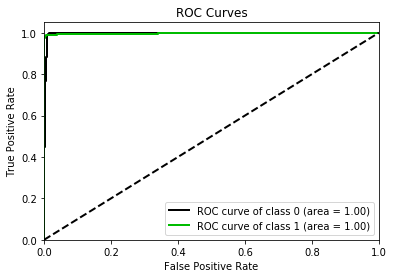

In [67]:
y_predicted_cat = pipeline.predict_proba(X_test)
y_pred = pipeline.predict(X_test)

from sklearn.metrics import roc_auc_score
cat_auc = roc_auc_score(y_test,y_predicted_cat[:,1])
print("El valor del AUC es: ", cat_auc)
from scikitplot.metrics import plot_roc
%matplotlib inline
plot_roc(y_test,y_predicted_cat, plot_micro = False, plot_macro= False)

In [68]:
# Matriz de Confusión
conf = confusion_matrix(y_test, y_pred)
predicted_cols = ['pred_'+str(c) for c in le.classes_]
display(pd.DataFrame(conf, index= ['real_Human','real_Bot'],columns = ['pred_Human','pred_Bot']))
print(classification_report(y_test, y_pred))

,pred_Human,pred_Bot
real_Human,275,2
real_Bot,16,1206


             precision    recall  f1-score   support

          0       0.95      0.99      0.97       277
          1       1.00      0.99      0.99      1222

avg / total       0.99      0.99      0.99      1499



In [69]:
# Re-Entrenar con el dataset completo
modelo = pipeline.fit(completeDf, le.transform(completeDf['bot']))

Learning rate set to 0.027812
0:	learn: 0.6138344	total: 50.2ms	remaining: 50.1s
1:	learn: 0.5584835	total: 99ms	remaining: 49.4s
2:	learn: 0.5023722	total: 145ms	remaining: 48.2s
3:	learn: 0.4580303	total: 189ms	remaining: 47s
4:	learn: 0.4154509	total: 244ms	remaining: 48.6s
5:	learn: 0.3752353	total: 288ms	remaining: 47.7s
6:	learn: 0.3399039	total: 332ms	remaining: 47.2s
7:	learn: 0.3074321	total: 377ms	remaining: 46.8s
8:	learn: 0.2830649	total: 428ms	remaining: 47.1s
9:	learn: 0.2614789	total: 473ms	remaining: 46.8s
10:	learn: 0.2395333	total: 518ms	remaining: 46.6s
11:	learn: 0.2234945	total: 563ms	remaining: 46.4s
12:	learn: 0.2075203	total: 614ms	remaining: 46.6s
13:	learn: 0.1931205	total: 658ms	remaining: 46.3s
14:	learn: 0.1787033	total: 702ms	remaining: 46.1s
15:	learn: 0.1663296	total: 745ms	remaining: 45.8s
16:	learn: 0.1563735	total: 795ms	remaining: 46s
17:	learn: 0.1468875	total: 840ms	remaining: 45.8s
18:	learn: 0.1385625	total: 884ms	remaining: 45.6s
19:	learn: 0.13

162:	learn: 0.0287258	total: 8.02s	remaining: 41.2s
163:	learn: 0.0287114	total: 8.07s	remaining: 41.1s
164:	learn: 0.0285945	total: 8.11s	remaining: 41s
165:	learn: 0.0285211	total: 8.15s	remaining: 41s
166:	learn: 0.0283169	total: 8.2s	remaining: 40.9s
167:	learn: 0.0282320	total: 8.26s	remaining: 40.9s
168:	learn: 0.0281876	total: 8.3s	remaining: 40.8s
169:	learn: 0.0280426	total: 8.35s	remaining: 40.8s
170:	learn: 0.0279279	total: 8.4s	remaining: 40.7s
171:	learn: 0.0279056	total: 8.45s	remaining: 40.7s
172:	learn: 0.0278542	total: 8.5s	remaining: 40.6s
173:	learn: 0.0277672	total: 8.54s	remaining: 40.5s
174:	learn: 0.0277522	total: 8.59s	remaining: 40.5s
175:	learn: 0.0277408	total: 8.64s	remaining: 40.5s
176:	learn: 0.0276911	total: 8.69s	remaining: 40.4s
177:	learn: 0.0276702	total: 8.73s	remaining: 40.3s
178:	learn: 0.0275232	total: 8.78s	remaining: 40.3s
179:	learn: 0.0274102	total: 8.84s	remaining: 40.3s
180:	learn: 0.0273661	total: 8.87s	remaining: 40.1s
181:	learn: 0.027334

323:	learn: 0.0213526	total: 15.5s	remaining: 32.4s
324:	learn: 0.0212646	total: 15.5s	remaining: 32.3s
325:	learn: 0.0212166	total: 15.6s	remaining: 32.2s
326:	learn: 0.0211801	total: 15.6s	remaining: 32.2s
327:	learn: 0.0211118	total: 15.7s	remaining: 32.1s
328:	learn: 0.0211105	total: 15.7s	remaining: 32s
329:	learn: 0.0210975	total: 15.8s	remaining: 32s
330:	learn: 0.0210695	total: 15.8s	remaining: 31.9s
331:	learn: 0.0209847	total: 15.8s	remaining: 31.9s
332:	learn: 0.0209731	total: 15.9s	remaining: 31.8s
333:	learn: 0.0209486	total: 15.9s	remaining: 31.8s
334:	learn: 0.0209203	total: 16s	remaining: 31.7s
335:	learn: 0.0209182	total: 16s	remaining: 31.7s
336:	learn: 0.0208694	total: 16.1s	remaining: 31.6s
337:	learn: 0.0208001	total: 16.1s	remaining: 31.6s
338:	learn: 0.0207774	total: 16.2s	remaining: 31.5s
339:	learn: 0.0207762	total: 16.2s	remaining: 31.4s
340:	learn: 0.0207718	total: 16.2s	remaining: 31.4s
341:	learn: 0.0206924	total: 16.3s	remaining: 31.3s
342:	learn: 0.020577

483:	learn: 0.0168843	total: 23.3s	remaining: 24.9s
484:	learn: 0.0168826	total: 23.4s	remaining: 24.8s
485:	learn: 0.0168411	total: 23.5s	remaining: 24.8s
486:	learn: 0.0167405	total: 23.5s	remaining: 24.8s
487:	learn: 0.0167326	total: 23.6s	remaining: 24.8s
488:	learn: 0.0166816	total: 23.7s	remaining: 24.7s
489:	learn: 0.0166312	total: 23.7s	remaining: 24.7s
490:	learn: 0.0165813	total: 23.8s	remaining: 24.7s
491:	learn: 0.0165734	total: 23.9s	remaining: 24.6s
492:	learn: 0.0165696	total: 23.9s	remaining: 24.6s
493:	learn: 0.0165619	total: 24s	remaining: 24.6s
494:	learn: 0.0165229	total: 24s	remaining: 24.5s
495:	learn: 0.0164997	total: 24.1s	remaining: 24.5s
496:	learn: 0.0164601	total: 24.1s	remaining: 24.4s
497:	learn: 0.0164478	total: 24.2s	remaining: 24.4s
498:	learn: 0.0164247	total: 24.2s	remaining: 24.3s
499:	learn: 0.0163825	total: 24.3s	remaining: 24.3s
500:	learn: 0.0163811	total: 24.3s	remaining: 24.2s
501:	learn: 0.0163624	total: 24.4s	remaining: 24.2s
502:	learn: 0.01

645:	learn: 0.0142217	total: 31.5s	remaining: 17.3s
646:	learn: 0.0142131	total: 31.6s	remaining: 17.2s
647:	learn: 0.0141965	total: 31.6s	remaining: 17.2s
648:	learn: 0.0141623	total: 31.7s	remaining: 17.1s
649:	learn: 0.0141619	total: 31.7s	remaining: 17.1s
650:	learn: 0.0140976	total: 31.8s	remaining: 17s
651:	learn: 0.0140958	total: 31.9s	remaining: 17s
652:	learn: 0.0140753	total: 31.9s	remaining: 17s
653:	learn: 0.0140484	total: 32s	remaining: 16.9s
654:	learn: 0.0140426	total: 32s	remaining: 16.9s
655:	learn: 0.0140084	total: 32.1s	remaining: 16.8s
656:	learn: 0.0140056	total: 32.1s	remaining: 16.8s
657:	learn: 0.0140020	total: 32.1s	remaining: 16.7s
658:	learn: 0.0140014	total: 32.2s	remaining: 16.7s
659:	learn: 0.0140004	total: 32.3s	remaining: 16.6s
660:	learn: 0.0139847	total: 32.3s	remaining: 16.6s
661:	learn: 0.0139810	total: 32.4s	remaining: 16.5s
662:	learn: 0.0139801	total: 32.5s	remaining: 16.5s
663:	learn: 0.0139582	total: 32.5s	remaining: 16.5s
664:	learn: 0.0139579	

807:	learn: 0.0124014	total: 40s	remaining: 9.5s
808:	learn: 0.0123624	total: 40s	remaining: 9.46s
809:	learn: 0.0123624	total: 40.1s	remaining: 9.4s
810:	learn: 0.0123538	total: 40.1s	remaining: 9.36s
811:	learn: 0.0123536	total: 40.2s	remaining: 9.31s
812:	learn: 0.0123464	total: 40.2s	remaining: 9.26s
813:	learn: 0.0123463	total: 40.3s	remaining: 9.21s
814:	learn: 0.0123363	total: 40.4s	remaining: 9.16s
815:	learn: 0.0123317	total: 40.4s	remaining: 9.11s
816:	learn: 0.0123313	total: 40.5s	remaining: 9.06s
817:	learn: 0.0123299	total: 40.5s	remaining: 9.01s
818:	learn: 0.0123142	total: 40.6s	remaining: 8.96s
819:	learn: 0.0123138	total: 40.6s	remaining: 8.91s
820:	learn: 0.0123127	total: 40.7s	remaining: 8.87s
821:	learn: 0.0123123	total: 40.7s	remaining: 8.82s
822:	learn: 0.0122927	total: 40.8s	remaining: 8.77s
823:	learn: 0.0122074	total: 40.8s	remaining: 8.72s
824:	learn: 0.0121859	total: 40.9s	remaining: 8.67s
825:	learn: 0.0121801	total: 40.9s	remaining: 8.62s
826:	learn: 0.0121

966:	learn: 0.0110659	total: 47.7s	remaining: 1.63s
967:	learn: 0.0110653	total: 47.7s	remaining: 1.58s
968:	learn: 0.0110649	total: 47.8s	remaining: 1.53s
969:	learn: 0.0110611	total: 47.8s	remaining: 1.48s
970:	learn: 0.0110224	total: 47.9s	remaining: 1.43s
971:	learn: 0.0110221	total: 47.9s	remaining: 1.38s
972:	learn: 0.0110217	total: 47.9s	remaining: 1.33s
973:	learn: 0.0110214	total: 48s	remaining: 1.28s
974:	learn: 0.0110155	total: 48s	remaining: 1.23s
975:	learn: 0.0109999	total: 48.1s	remaining: 1.18s
976:	learn: 0.0109954	total: 48.1s	remaining: 1.13s
977:	learn: 0.0109954	total: 48.2s	remaining: 1.08s
978:	learn: 0.0109922	total: 48.2s	remaining: 1.03s
979:	learn: 0.0109869	total: 48.3s	remaining: 985ms
980:	learn: 0.0109868	total: 48.3s	remaining: 936ms
981:	learn: 0.0109808	total: 48.4s	remaining: 886ms
982:	learn: 0.0109743	total: 48.4s	remaining: 837ms
983:	learn: 0.0109737	total: 48.4s	remaining: 788ms
984:	learn: 0.0109560	total: 48.5s	remaining: 738ms
985:	learn: 0.01

In [84]:
# # Exportar Modelo a archivo binario
filename = 'modeloCompleto.pkl'
with open(filename, 'wb') as twModel:
    pickle.dump(modelo, twModel)

In [73]:
twDataTransform

__main__.twDataTransform

In [80]:
with open('twDataTransform.pkl', 'wb') as output:
    pickle.dump(twDataTransform, output, )

In [81]:
with open('twDataTransform.pkl', 'rb') as a:
    twDataTransformLoadedTest = pickle.load(a)

In [82]:
twDataTransformLoadedTest

__main__.twDataTransform

In [83]:
pickle.dumps(twDataTransform)

b'\x80\x03c__main__\ntwDataTransform\nq\x00.'